In [1]:
from getdist import plots, MCSamples
%matplotlib inline
from matplotlib import pyplot as plt
import getdist
import numpy as np
import os

In [2]:
DCOLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Galaxy density distribution per $z$-bin

In [45]:
dndz_redmagic = []
dndz_metacal = []
dndz_im3shape = []

zbins_gc = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
zbins_wl = [0.2, 0.43, 0.63, 0.9, 1.3]

for i in range(5):
    dndz_redmagic.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_clustering/dndz_bin{}.txt'.format(i)))

for i in range(4):
    dndz_metacal.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/dndz_metacal_bin{}.txt'.format(i)))
    dndz_im3shape.append(np.loadtxt('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/dndz_im3shape_bin{}.txt'.format(i)))

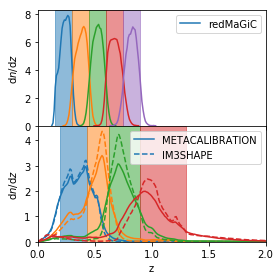

In [75]:
f, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={'hspace':0, 'wspace':0})

for i, dndzi in enumerate(dndz_redmagic):
    sel = dndzi[:, -1] > 5e-3
    axs[0].plot(dndzi[sel, 1], dndzi[sel, -1], c=DCOLORS[i], label='redMaGiC' if not i else '')
    axs[0].axvspan(zbins_gc[i], zbins_gc[i+1], color=DCOLORS[i], alpha=0.5)

for i, dndzi in enumerate(dndz_metacal):
    axs[1].plot(dndzi[:,1], dndzi[:, -1], c=DCOLORS[i], label='METACALIBRATION' if not i else '')
    axs[1].plot(dndz_im3shape[i][:,1], dndz_im3shape[i][:, -1], c=DCOLORS[i], ls='--', label='IM3SHAPE'if not i else '')
    axs[1].axvspan(zbins_wl[i], zbins_wl[i+1], color=DCOLORS[i], alpha=0.5)

axs[0].legend(loc=0)
axs[1].legend(loc=1)

axs[0].set_ylim([0, None])
axs[1].set_ylim([0, None])

axs[0].set_ylabel('$\mathrm{d}n/\mathrm{d}z$')
axs[1].set_ylabel('$\mathrm{d}n/\mathrm{d}z$')
axs[1].set_xlabel('z')

plt.xlim([0, 2])
plt.tight_layout()
plt.savefig('./figures/dndz-bins.pdf')
plt.show()
plt.close()

# $C_\ell$

In [37]:
def load_thcls(th_outdir, file_prefix, nmaps):
    cls_arr = []
    for i in range(nmaps):
        for j in range(i, nmaps):
            fname = os.path.join(th_outdir, file_prefix + '_{}_{}.txt'.format(i, j))
            if not os.path.isfile(fname): #spin0-spin0
                raise ValueError('Missing workspace: ', fname)

            cls_arr.append(np.loadtxt(fname, usecols=1))

    ell = np.loadtxt(fname, usecols=0)

    return ell, np.array(cls_arr)

def load_thcls_gk(nmaps_g, nmaps_k):
    th_outdir = '/mnt/extraspace/evam/S8z/Clsgk/'
    file_prefix = 'DES_Cls_gk_lmax3xNside'
    cls_arr = []
    for i in range(nmaps_g):
        for j in range(nmaps_k):
            fname = os.path.join(th_outdir, file_prefix + '_{}_{}.txt'.format(i, j))
            if not os.path.isfile(fname): #spin0-spin0
                raise ValueError('Missing workspace: ', fname)

            cls_arr.append(np.loadtxt(fname, usecols=1))

    ell = np.loadtxt(fname, usecols=0)

    return ell, np.array(cls_arr)

def load_thcls_Planck():
    fdir = '/mnt/extraspace/evam/S8z/ClsPlanck/'
    cls_arr = []
    for i in range(5):
        fname = os.path.join(fdir, 'DESPlanck_Cls_gk_lmax3xNside_{}.txt'.format(i))
        cls_arr.append(np.loadtxt(fname, usecols=1))
    for i in range(4):
        fname = os.path.join(fdir, 'DESPlanck_Cls_kk_lmax3xNside_{}.txt'.format(i))
        cls_arr.append(np.loadtxt(fname, usecols=1)) 
        cls_arr.append(cls_arr[-1] * 0)

    fname = os.path.join(fdir, 'Planck_Cls_kk_lmax3xNside.txt'.format(i))
    cls_arr.append(np.loadtxt(fname, usecols=1))
    ell = np.loadtxt(fname, usecols=0)
    
    return ell, np.array(cls_arr)

def load_cls_all_matrix_th():
    # All th_ell are the same
    th_outdir = '/mnt/extraspace/evam/S8z/Clsgg/'
    th_ell, Clsgg_ar = load_thcls(th_outdir, 'DES_Cls_lmax3xNside', 5)

    th_outdir = '/mnt/extraspace/evam/S8z/Clskk/'
    th_ell, Clskk_ar = load_thcls(th_outdir, 'DES_Cls_kk_lmax3xNside', 4)

    th_outdir = '/mnt/extraspace/evam/S8z/Clsgk/'
    th_ell, Clsgk_ar = load_thcls_gk(5, 4)

    th_outdir = '/mnt/extraspace/evam/S8z/ClsPlanck/'
    th_ell, ClsPlanck_ar = load_thcls_Planck()
    
    # Checked that all EE's are the same as in the array.
    Clskk_full_mat = np.zeros((8, 8, th_ell.shape[0]))
    i, j = np.triu_indices(4)
    Clskk_full_mat[::2, ::2][i, j] = Clskk_ar
    Clskk_full_mat[::2, ::2][j, i] = Clskk_ar
    i, j = np.triu_indices(8)
    Clskk_ar_full = Clskk_full_mat[i, j]
    
    th_cls_all = np.zeros((14, 14, th_ell.shape[0]))

    i, j = np.triu_indices(5)
    th_cls_all[:5, :5][i, j] = Clsgg_ar

    i, j = np.triu_indices(8)
    th_cls_all[5:-1, 5:-1][i, j] = Clskk_ar_full

    th_cls_all[:, -1] = ClsPlanck_ar

    for i in range(5):
        th_cls_all[i, 5:-1:2] = Clsgk_ar[i * 4 : (i + 1) * 4]

    i, j = np.triu_indices(14)
    th_cls_all_ar = th_cls_all[i, j]
    th_cls_all[j, i] = th_cls_all_ar
    
    return th_ell, th_cls_all

### We could import the autocorr and plot the cls with their error.
def load_thErrors():
    outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 
    surveys = ['DESgc', 'DESwl', 'PLAcv']
    dsets = []
    for i in range(5):
        dsets.append(surveys[0] + str(i))
    for i in range(4):
        dsets.append(surveys[1] + str(i))
        
    dsets.append(surveys[2])
    
    th_err = []
    for c1, d1 in enumerate(dsets):
        for d2 in dsets[c1:]:
            fname = os.path.join(outdir, 'cov_{0}_{1}_{0}_{1}.npz'.format(d1, d2))
            th_err.append(np.sqrt(np.diag(np.load(fname)['arr_0'])))
    return np.array(th_err)


In [38]:
th_err = load_thErrors()

/mnt/extraspace/gravityls_3/S8z/Cls/all_together/cov_PLAcv_PLAcv_PLAcv_PLAcv.npz


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [33]:
th_err.shape

(55, 39)

In [3]:
############# Load theory cl matrix 

th_ell, th_cls_all = load_cls_all_matrix_th()

############# Load obs. cl matrix

outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 

lbpw_obs_cls_all = np.load(os.path.join(outdir, 'cl_all_no_noise.npz'))
lbpw, obs_cls_all = lbpw_obs_cls_all['l'], lbpw_obs_cls_all['cls']

lbpw_obs_cls_all = np.load(os.path.join(outdir, 'cl_all_with_noise.npz'))
lbpw, obs_cls_all_wn = lbpw_obs_cls_all['l'], lbpw_obs_cls_all['cls']

############### Load DES sh. noise

outdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/' 
desgc_nls_arr = np.load(os.path.join(outdir, 'des_w_cl_shot_noise_ns4096.npz'))['cls']
dessh_nls_arr = np.load(os.path.join(outdir, 'des_sh_metacal_rot0-10_noise_ns4096.npz'))['cls']

############### Load Theoretical errors
th_err = load_thErrors()

1.9675039393930176
8.67393638621147
7.349664242311528
5.790025375784253
3.899118776676901
4.778754840885101
2.551047184674564
8.540491652683913
3.261309284905762
1.6076428434368568
3.868426400320144
1.746838311120116
5.119017854332052
3.4739363325946195


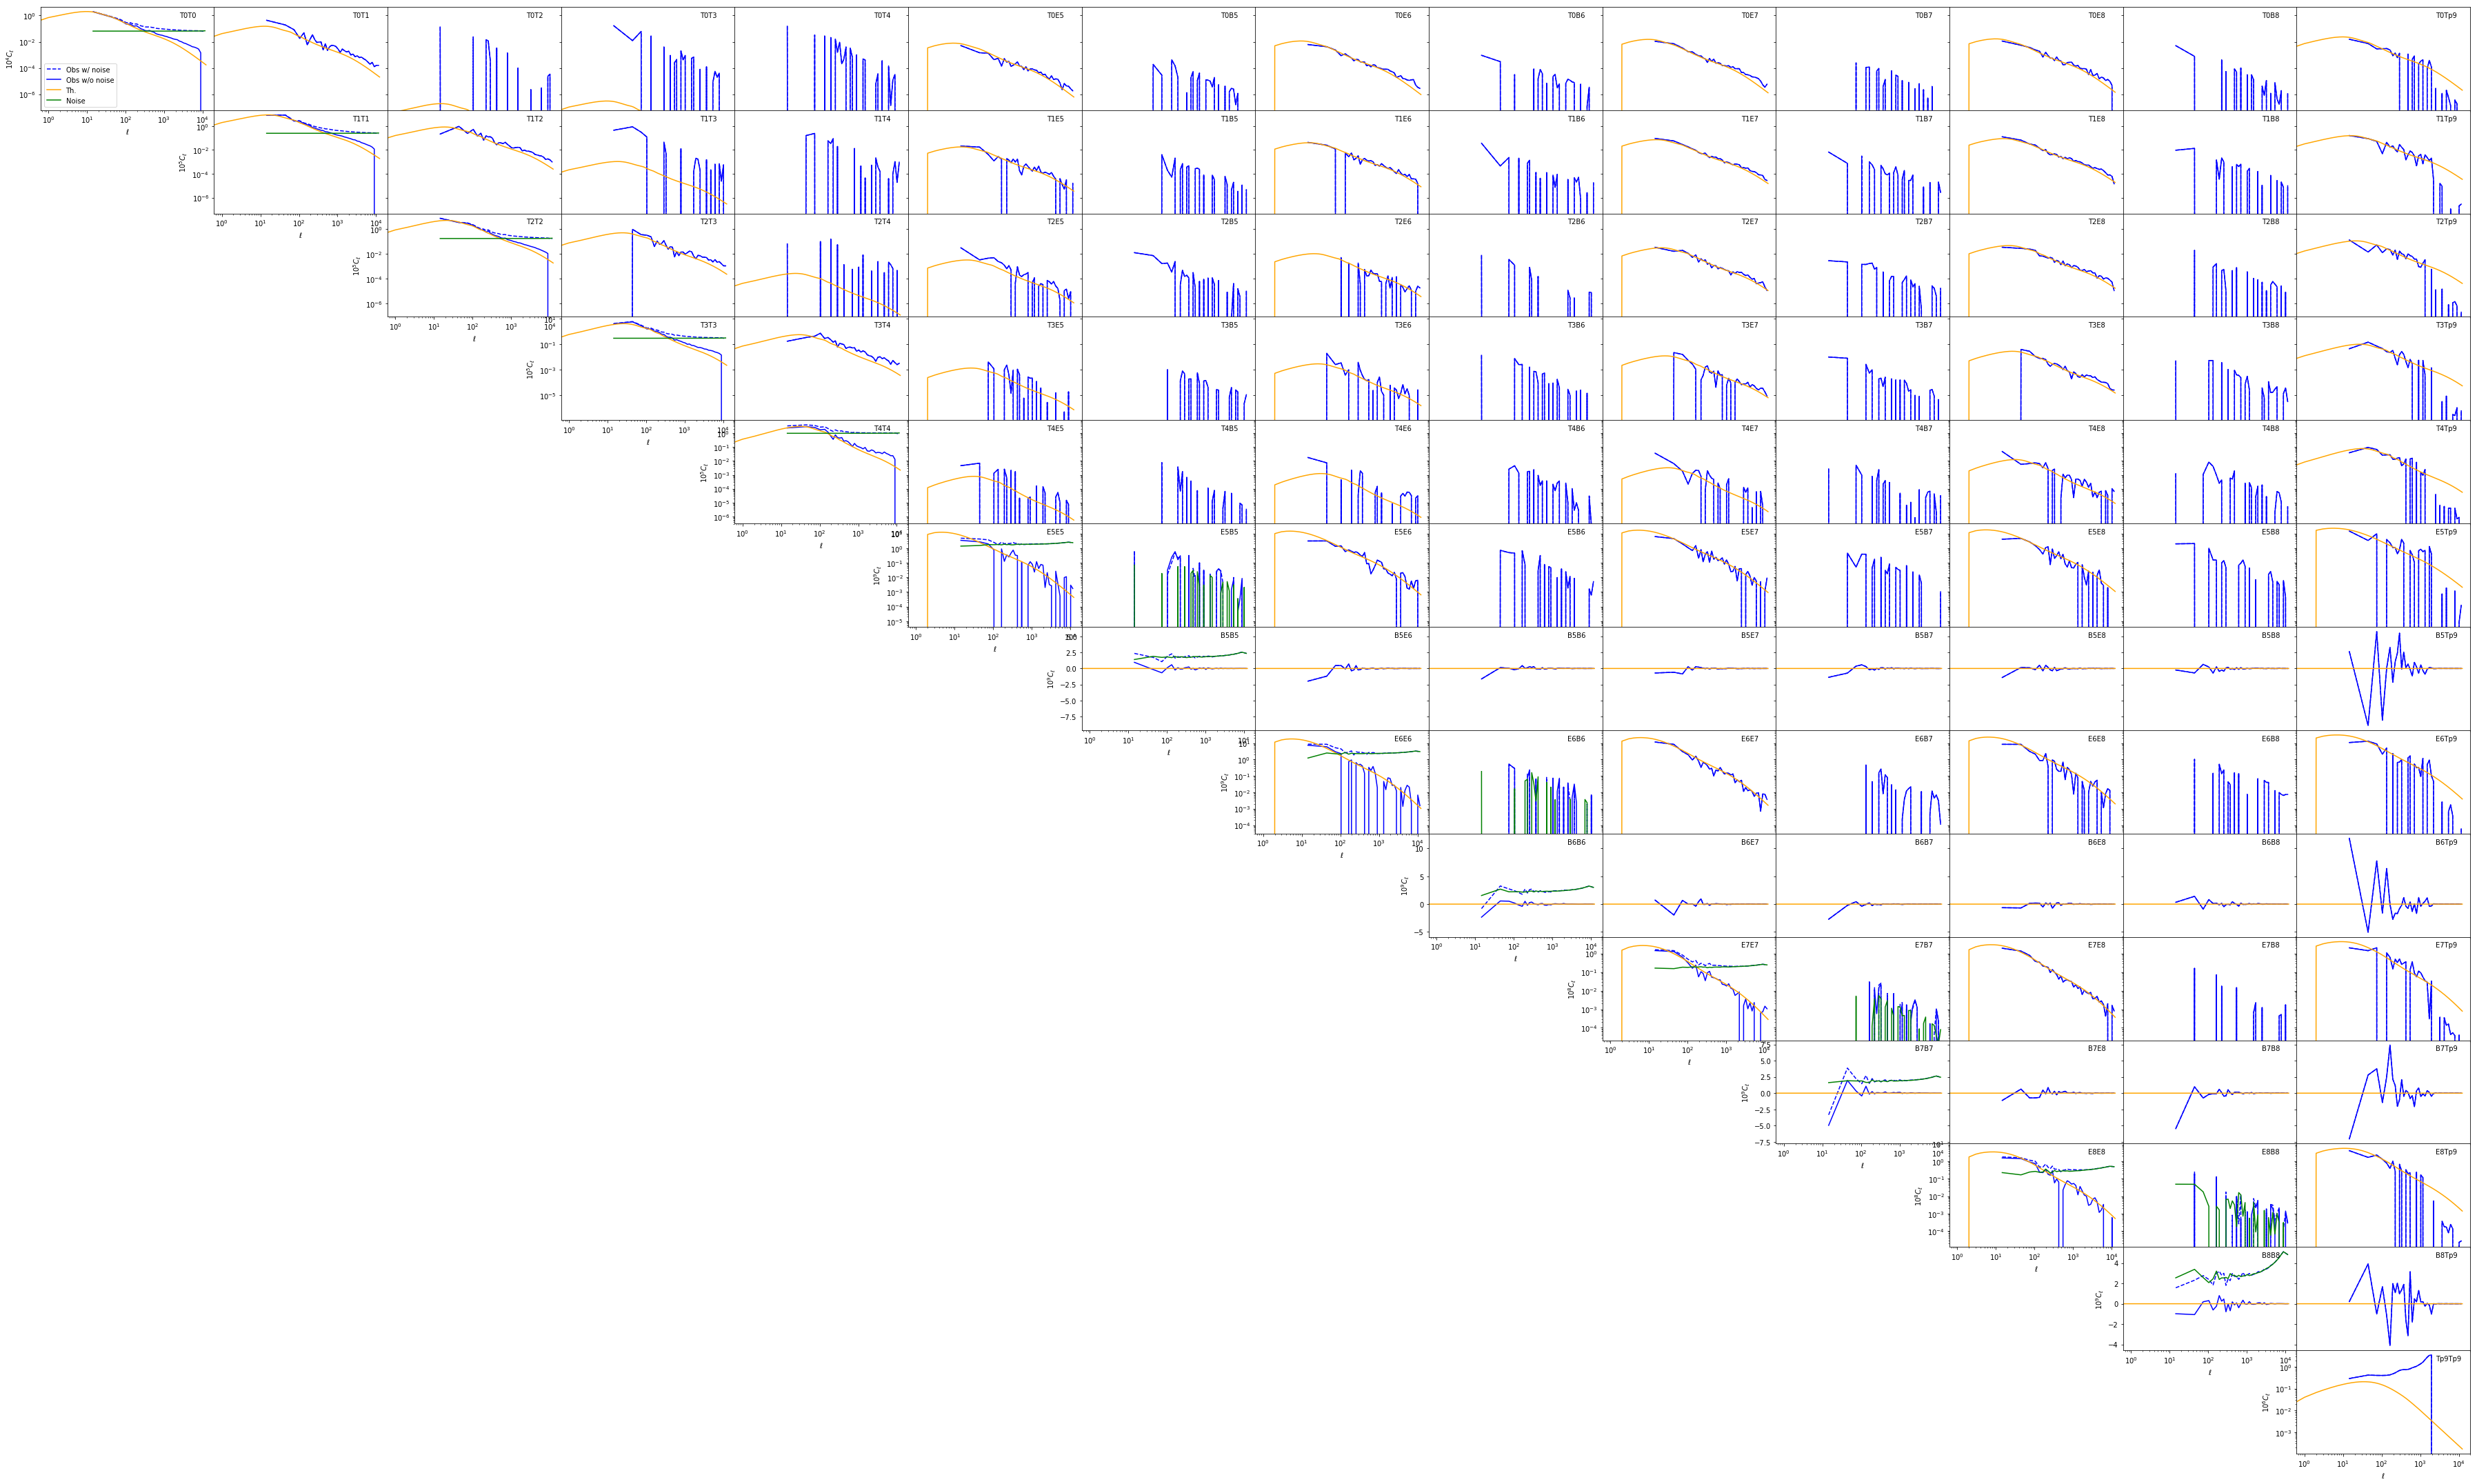

In [5]:
f, axs = plt.subplots(14, 14, figsize=(50, 30), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})

labels = ['T0', 'T1', 'T2', 'T3', 'T4', 'E5', 'B5', 'E6', 'B6', 'E7', 'B7', 'E8', 'B8', 'Tp9']


ordmag = np.zeros(14)

for i in range(14):
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag[i] = 10 ** floor
    
    for j in range(i, 14):
        axs[i, j].semilogx(lbpw, obs_cls_all_wn[i, j] * ordmag[i], c='blue', ls='--', label='Obs w/ noise')
        axs[i, j].semilogx(lbpw, obs_cls_all[i, j] * ordmag[i], c='blue', label='Obs w/o noise')
        axs[i, j].semilogx(th_ell, th_cls_all[i, j] * ordmag[i], c='orange', label='Th.')
        if not np.all(th_cls_all[i, j] == 0):
            axs[i, j].set_yscale('log')
            
        axs[i, j].text(0.8, 0.9, labels[i] + labels[j],  transform=axs[i,j].transAxes)
        
        if i != j:
            axs[j, i].set_visible(False)
        else:
            print(np.max(np.abs(obs_cls_all_wn[i, i])) * ordmag[i])
            axs[i, i].set_xlabel(r'$\ell$')
            axs[i, i].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
            axs[i, i].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[i, i].yaxis.set_tick_params(which='both', labelbottom=True)

        
for i in range(5):   
    axs[i, i].semilogx(lbpw, desgc_nls_arr[i] * ordmag[i], c='green', label='Noise')

for i in range(4):
    ixplot = 5 + i * 2
    
    axs[ixplot, ixplot].semilogx(lbpw, dessh_nls_arr[i, 0, 0] * ordmag[ixplot], c='green', label='Noise')
    axs[ixplot, ixplot + 1].semilogx(lbpw, dessh_nls_arr[i, 0, 1] * ordmag[ixplot], c='green', label='Noise')
    axs[ixplot + 1, ixplot + 1].semilogx(lbpw, dessh_nls_arr[i, 1, 1] * ordmag[ixplot + 1], c='green', label='Noise')



axs[0,0].legend(loc=0)
plt.tight_layout()
plt.savefig('figures/cls_all.pdf')
plt.show()
plt.close()

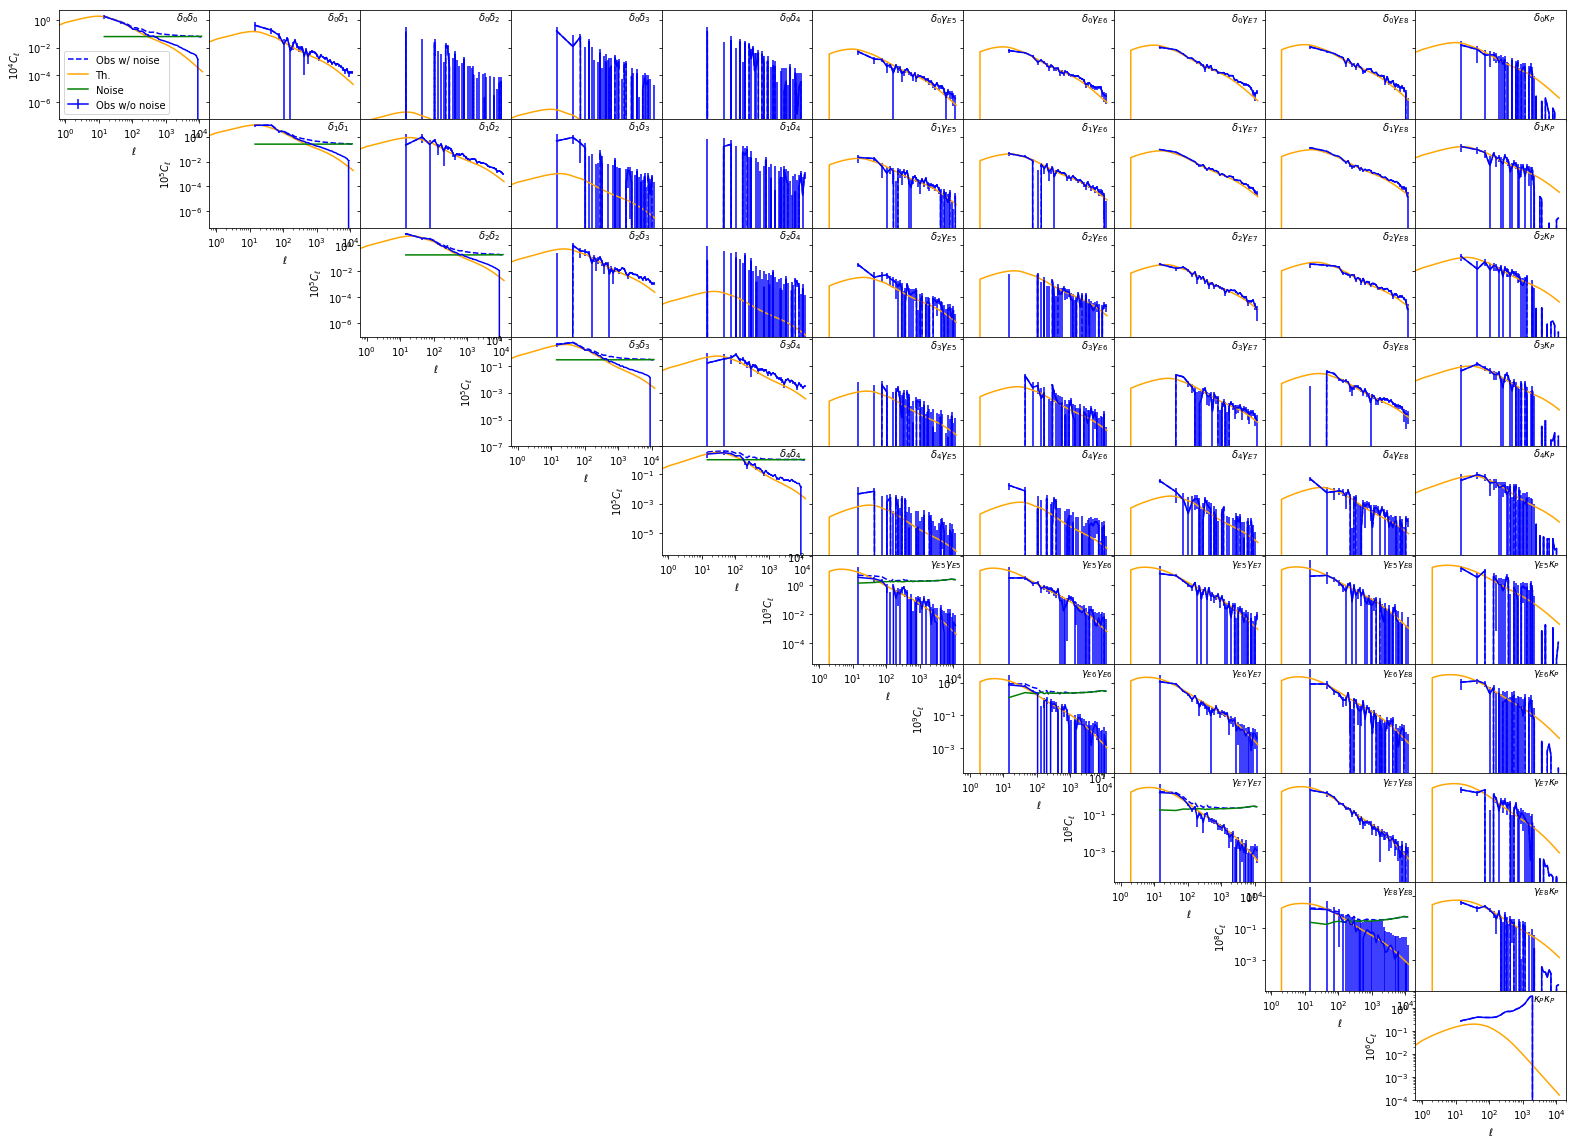

In [47]:
f, axs = plt.subplots(10, 10, figsize=(22, 16), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})

labels = ['\delta_0', '\delta_1', '\delta_2', '\delta_3', '\delta_4',
          '\gamma_{E5}', '\gamma_{B5}', '\gamma_{E6}', '\gamma_{B6}', 
          '\gamma_{E7}', '\gamma_{B7}', '\gamma_{E8}', '\gamma_{B8}', 
          '\kappa_P']


ordmag = np.zeros(14)

ixplot = jxplot = 0
count = 0
for i in range(14):
    if 'B' in labels[i]:
        continue
    floor = - np.floor(np.log10(np.max(obs_cls_all_wn[i, i])))
    ordmag[i] = 10 ** floor
    
    jxplot = ixplot
    for j in range(i, 14):
        if 'B' in labels[j]:
            continue
            
        axs[ixplot, jxplot].semilogx(lbpw, obs_cls_all_wn[i, j] * ordmag[i], c='blue', ls='--', label='Obs w/ noise')
        # axs[ixplot, jxplot].semilogx(lbpw, obs_cls_all[i, j] * ordmag[i], c='blue', label='Obs w/o noise')
        axs[ixplot, jxplot].errorbar(lbpw, obs_cls_all[i, j] * ordmag[i], yerr=th_err[count] * ordmag[i],
                                     c='blue', label='Obs w/o noise')
        axs[ixplot, jxplot].semilogx(th_ell, th_cls_all[i, j] * ordmag[i], c='orange', label='Th.')
        if not np.all(th_cls_all[i, j] == 0):
            axs[ixplot, jxplot].set_yscale('log')
            
        axs[ixplot, jxplot].text(0.78, 0.9, '${}$'.format(labels[i] + labels[j]),
                                 transform=axs[ixplot,jxplot].transAxes)
        
        if i != j:
            axs[jxplot, ixplot].set_visible(False)
        else:
            axs[ixplot, ixplot].set_xlabel(r'$\ell$')
            axs[ixplot, ixplot].set_ylabel(r'$10^{{ {} }} C_{{\ell}}$'.format(int(floor)))
            axs[ixplot, ixplot].xaxis.set_tick_params(which='both', labelbottom=True)
            axs[ixplot, ixplot].yaxis.set_tick_params(which='both', labelbottom=True)
            
        jxplot += 1
        count += 1
    ixplot += 1

        
for i in range(5):   
    axs[i, i].semilogx(lbpw, desgc_nls_arr[i] * ordmag[i], c='green', label='Noise')

for i in range(4):
    axs[5 + i, 5 + i].semilogx(lbpw, dessh_nls_arr[i, 0, 0] * ordmag[5 + i * 2 ], c='green', label='Noise')


axs[0,0].legend(loc=0)
plt.tight_layout()
plt.savefig('figures/cls_all_noBs.pdf')
plt.show()
plt.close()

# MCMC

In [3]:
MP_root = '/mnt/zfsusers/gravityls_3/codes/montepython_emilio'

## DES

In [4]:
des = getdist.loadMCSamples(os.path.join(MP_root, 'chains/cl_cross_corr_des_full/2020-02-26_1000000_'),
                           settings={'ignore_rows':0.1})

In [5]:
p = des.getParamNames()

In [6]:
p.list()

['Omega_b',
 'Omega_c',
 'A_s',
 'n_s',
 'h',
 'gc_b_0',
 'gc_b_1',
 'gc_b_2',
 'gc_b_3',
 'gc_b_4',
 'gc_dz_0',
 'gc_dz_1',
 'gc_dz_2',
 'gc_dz_3',
 'gc_dz_4',
 'wl_ia_A',
 'wl_ia_eta',
 'wl_m_0',
 'wl_m_1',
 'wl_m_2',
 'wl_m_3',
 'wl_dz_0',
 'wl_dz_1',
 'wl_dz_2',
 'wl_dz_3',
 'sigma_8',
 'Omega_m',
 'S_8']

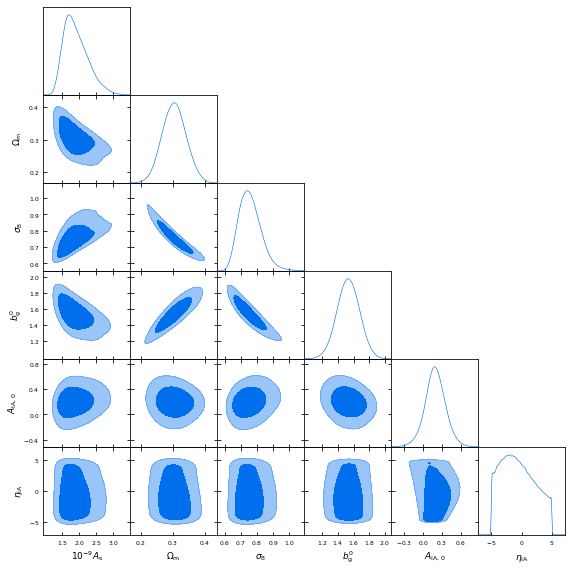

In [10]:
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([des], params=['A_s','Omega_m', 'sigma_8', 'gc_b_0', 'wl_ia_A','wl_ia_eta'],
                filled=True)
g.export('./figures/mcmc_des_full.pdf')
g.finish_plot()

## Growth modified (dpk1 free)

In [11]:
growth = getdist.loadMCSamples(os.path.join(MP_root, 'chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000_'),
                           settings={'ignore_rows':0.1})

/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__1.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__2.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__3.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__4.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__5.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__6.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__7.txt
/mnt/zfsusers/gravityls_3/codes/montepython_emilio/chains/cl_cross_corr_des_growth_dpk0_fixed/2020-03-04_1000000__8.txt
Removed 0.1 as burn in


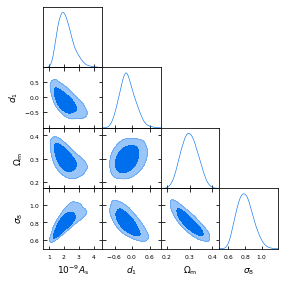

In [34]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([growth], params=['A_s', 'dpk1', 'Omega_m', 'sigma_8'],
                filled=True)
g.export('./figures/mcmc_growth_dpk0_fixed.pdf')
g.finish_plot()

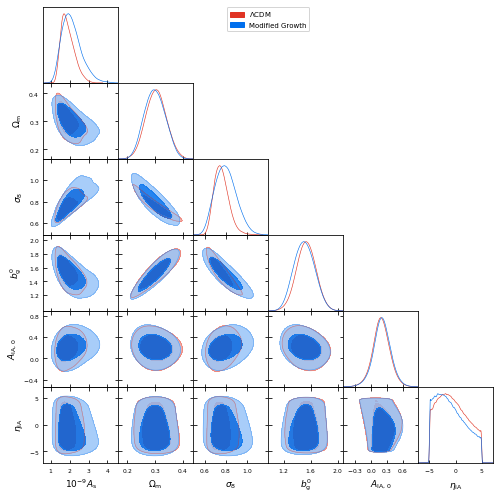

In [33]:
g = plots.get_subplot_plotter(width_inch=7)
g.triangle_plot([des, growth], params=['A_s', 'Omega_m', 'sigma_8', 'gc_b_0', 'wl_ia_A','wl_ia_eta'],
                filled=True, legend_labels=[r'$\Lambda$CDM', 'Modified Growth'])
g.export('./figures/mcmc_des_and_growth_dpk0_fixed.pdf')
g.finish_plot()

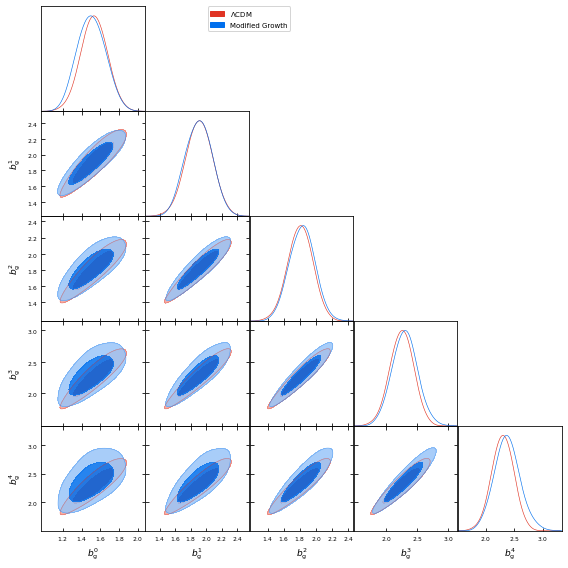

In [25]:
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([des, growth], params=['gc_b_0', 'gc_b_1', 'gc_b_2', 'gc_b_3', 'gc_b_4'],
                filled=True, legend_labels=[r'$\Lambda$CDM', 'Modified Growth'])
g.finish_plot()